### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

План занятия:

1. задача сегментации аудитории по интересам - для чего
2. тематическое моделирование - получаем эмбединги текстов
3. решаем downstream-задачу (профилирование аудитории новостного портала)

Рассматривать мы все будем в контексте решения конкретной прикладной задачи - задачи оттока

#### Задача сегментации (неформальное определение)

Разбиваем пользователей на группы, чем-то отличающиеся друг от друга

Если же более формально, то:

Сегментация клиентской базы — это способ повышения эффективности работы с пользователями путем их распределения по отдельным группам, или сегментам, в соответствии с их запросами и/или потребностями.

Сегментация может быть очень разной:

#### 1. когда совершил первую покупку (сколько прошло с момента регистрации до момента покупки)

![ab_split](payments1.png "Payments2")

#### 2. по психотипам

![ab_split](psycho.png "Psycho")

#### 3. по платежам

![ab_split](payments.png "Payments")

#### 4. По эффективности взаимодействия (uplift)

![ab_split](uplift.png "Uplift")

#### 5. по интересам

![ab_split](interests.png "Interests")

И еще 100500 вариантов сегментирования, которое может быть полезно. 

Для чего полезно?

1. понимание аудитории, способность описать основные группы пользователей и их интересы
2. выявление сегментов с максимальной монетизацией
3. выбор маркетинговой стратегии
4. налаживание эффективного взаимодействия с пользователями

#### Пример из жизни (новостной портал)

Представим, что мы - компания-агрегатор новостей (новостной портал).

У нас есть:

1. читатели
2. новости

Для каждого пользователя мы можем за какой-то период (например, 1 день) достать из базы данных список прочитанных им новостей.

Для каждой новости мы можем вытащить текст и метаинформацию.

### Задача #1: нужно построить модель прогнозирования оттока - это наша downstream-задача. 

Нам нужны:

1. векторное представление пользователя
2. сегменты, описывающие интересы пользователя

p.s. в контексте нашей задачи - это одно и то же

### С чего начнем?

С векторного представления и сегментов новостей!

Есть два очевидных варианта как это сделать:

1. многоклассовая классификация
2. кластеризация документов с последующей попыткой их (кластера) интерпретировать

Проблема:

1. для классификации нам нужно сначала разметить новости - привлечение ручного труда

### Задача тематического моделирования

#### Неформально!

- на свете бывают темы (заранее неизвестные), которые отражают то, о чём могут быть части документа;
- каждая тема – это распределение вероятностей на словах, т.е. мешок слов, из которого можно с разной вероятностью вытащить разные слова;
- каждый документ – это смесь тем, т.е. распределение вероятностей на темах, кубик, который можно кинуть;
- процесс порождения каждого слова состоит в том, чтобы сначала выбрать тему по распределению, соответствующему документу, а затем выбрать слово из распределения, соответствующего этой теме.

Вероятностные модели удобно понимать и представлять в виде порождающих процессов (generative processes), когда мы последовательно описываем, как порождается одна единица данных, вводя по ходу дела все вероятностные предположения, которые мы в этой модели делаем. Соответственно, порождающий процесс для LDA должен последовательно описывать, как мы порождаем каждое слово каждого документа. И вот как это происходит (здесь и далее я буду предполагать, что длина каждого документа задана – её тоже можно добавить в модель, но обычно это ничего нового не даёт):

1. для каждой темы t выбираем вектор phi_t - распределение слов в теме

2. для каждого документа d:

    2.1 выбираем Theta_d - распределение тем в документе
    
    2.2 для каждого из слов документа w:
        2.2.1 выбираем тему z~Theta_d
        2.2.2 выбираем слово w~p(w|z, phi)

![lda](lda_simple.png "LDA")

ист. https://habr.com/ru/company/surfingbird/blog/230103/

#### Чуть более формально

Терминология:

1. документ - коллекция слов 
2. тема - набор токенов (слов), совместно часто встречающихся в документах

Более формально:

1. тема - условное распределение на множестве терминов, p(w|t)
2. тематический профиль документа - условное распределение тем p(t|d)

Вопрос: что же нам дано (в терминах условной вероятности)?

Ответ: условное распределение слов в документах - p(w|d)

Прекрасное объяснение от Воронцова - http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf

Тематическая модель позволяет нам получить p(w|t), p(t|d) по известным p(w|d)

![ab_split](tm1.png "TM1")

### ПЕРЕРЫВ ДО 21:02 (МСК)

### Переходим к практике

In [20]:
import pandas as pd

Наши новости

In [21]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [22]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [23]:
# !pip install gensim

In [24]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [25]:
# !pip install nltk

In [26]:
# !pip install razdel

In [27]:
# !pip install pymorphy2

In [30]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [37]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [38]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [39]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [40]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [41]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 32.1 s


In [42]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 4min 10s


А теперь в 3 строчки обучим нашу модель

In [43]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [44]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [45]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 49.2 s


In [46]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [47]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(8, 0.1414187),
 (12, 0.104610875),
 (19, 0.1965051),
 (22, 0.06433647),
 (24, 0.4751053)]

In [48]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: год это который суд статья снижение nn
topic_1: банк пациент законодательство норма фильм выдать юрист
topic_2: восток рекомендовать сон фронт сооружение артист компенсировать
topic_3: товар северный торговый китай праздник китайский южный
topic_4: компания эксперимент рубль чиновник задержать nn управление
topic_5: газ украина риск станция украинский двигатель предполагаться
topic_6: год который квартира банк завод продажа сделка
topic_7: млн проверка составить мышь медицина год сумма
topic_8: ракета эффективность япония агентство планета студент параметр
topic_9: который nn это произойти район источник находиться
topic_10: земля сша космос воздух день американский статья
topic_11: год который это ребёнок человек фонд научный
topic_12: мозг взрыв спрос топливо лаборатория всё это
topic_13: грунт армения дыра порт достопримечательность азербайджан ирландия
topic_14: население погибнуть город операция человек житель год
topic_15: год рост журнал тыс цена доход это
topic_16: рос

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [49]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [50]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.0,0.0,0.0,0.08392,0.222465,0.0,0.00000,...,0.0,0.306487,0.000000,0.0,0.000000,0.040977,0.0,0.000000,0.0,0.167247
1,4896,0.101725,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.00000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.280973
2,4897,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.14149,...,0.0,0.000000,0.000000,0.0,0.196263,0.000000,0.0,0.064339,0.0,0.475097
3,4898,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.00000,...,0.0,0.000000,0.466718,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.208299
4,4899,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.00000,...,0.0,0.169171,0.000000,0.0,0.643373,0.000000,0.0,0.000000,0.0,0.162939


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [51]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [52]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [53]:
doc_dict[293622]

array([0.16847098, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.042845  , 0.        , 0.        , 0.        ,
       0.17487858, 0.        , 0.        , 0.01711089, 0.105483  ,
       0.        , 0.18626691, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.2940228 , 0.        ])

In [54]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [55]:
get_user_embedding(user_articles_list)

array([0.07276927, 0.        , 0.        , 0.        , 0.01673213,
       0.01215226, 0.        , 0.        , 0.00403664, 0.02353768,
       0.02653325, 0.16123428, 0.        , 0.        , 0.01911704,
       0.06010438, 0.27274456, 0.03933789, 0.00201875, 0.1880527 ,
       0.04090792, 0.        , 0.        , 0.04325448, 0.        ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [56]:
#users['articles'].iloc[33]

In [57]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [58]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.129355,0.000000,0.000000,0.010889,0.010615,0.026659,0.026006,0.003318,0.007563,...,0.012655,0.165546,0.033614,0.000000,0.100543,0.085406,0.0,0.000000,0.049004,0.000000
1,u108690,0.088593,0.011962,0.000000,0.000000,0.055792,0.045193,0.011807,0.004623,0.019585,...,0.020322,0.147060,0.095433,0.005114,0.045882,0.159480,0.0,0.000000,0.019422,0.002809
2,u108339,0.079582,0.017231,0.002294,0.001709,0.024238,0.011400,0.023296,0.004144,0.001841,...,0.018732,0.150569,0.030941,0.003618,0.072879,0.103320,0.0,0.016304,0.043255,0.000000


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [59]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [60]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.129355,0.000000,0.000000,0.010889,0.010615,0.026659,0.026006,0.003318,0.007563,...,0.165546,0.033614,0.000000,0.100543,0.085406,0.0,0.000000,0.049004,0.000000,0
1,u108690,0.088593,0.011962,0.000000,0.000000,0.055792,0.045193,0.011807,0.004623,0.019585,...,0.147060,0.095433,0.005114,0.045882,0.159480,0.0,0.000000,0.019422,0.002809,1
2,u108339,0.079582,0.017231,0.002294,0.001709,0.024238,0.011400,0.023296,0.004144,0.001841,...,0.150569,0.030941,0.003618,0.072879,0.103320,0.0,0.016304,0.043255,0.000000,1


In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [62]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [63]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [64]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.28654645, 0.0763031 , 0.49568753, 0.12855969, 0.0994725 ,
       0.08726073, 0.12802589, 0.05751179, 0.13777852, 0.12975047])

In [65]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [66]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.234020, F-Score=0.624, Precision=0.538, Recall=0.743


In [67]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [69]:
import itertools

Confusion matrix, without normalization
[[1599  156]
 [  64  181]]


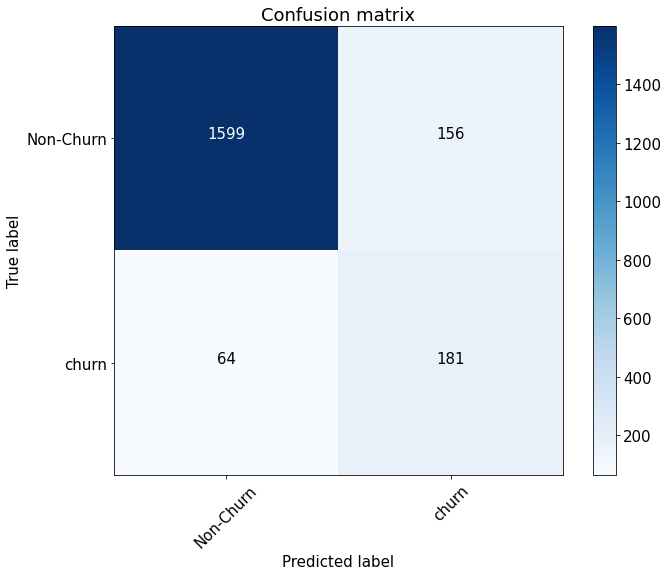

In [70]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [71]:
roc_auc_score(y_test, preds)

0.9258794115936974

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk